In [ ]:
# install the library gdown for downloading video from google drive
# install ffmpeg for handling video
#install google-auth and google-api-python-client for tackle with google drive api
!pip install gdown ffmpeg-python google-auth google-api-python-client

In [ ]:
# Import important libraries
import os
import glob
import ffmpeg
import gdown
from IPython.display import display, Image
from google.colab import drive
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload

In [ ]:
# Step 1: Download the Video
def download_video(url, output_path):
    """
    Download a video from a given URL to the specified output path.

    Args:
        url (str): The URL of the video to be download
        output_path (str): The path where the downloaded video will be saved

    Returns:
        str: the output path will the video was download on it.

    """
    gdown.download(url, output_path, quiet=False)
    return output_path

video_url = "https://drive.google.com/uc?id=1hotA1Bc_tDFxxE5I7EoJ3TL4_T6DHNX9&export=download"
download_path = "/content/Detective_Conan.mp4"

download_video_path = download_video(video_url, download_path)

Downloading...
From (original): https://drive.google.com/uc?id=1hotA1Bc_tDFxxE5I7EoJ3TL4_T6DHNX9&export=download
From (redirected): https://drive.google.com/uc?id=1hotA1Bc_tDFxxE5I7EoJ3TL4_T6DHNX9&export=download&confirm=t&uuid=171c41ad-420d-4f94-8986-024639a37399
To: /content/Detective_Conan.mp4
100%|██████████| 1.92G/1.92G [00:37<00:00, 50.5MB/s]


In [ ]:
# Step 2: Split the video into 4 parts
def split_video(video_path, part_duration):
    """
    Split a video into multiple parts of specified duration.

    Args:
        video_path (str): The path to the input video file.
        part_duration (int): The duration of each video part in seconds.
    """

    os.makedirs("/content/video_parts", exist_ok=True)
    video_info = ffmpeg.probe(video_path)
    video_duration = float(video_info['format']['duration'])

    for i in range(0, int(video_duration), part_duration):
      start_time = i
      end_time = min(i + part_duration, int(video_duration))
      output_path = os.path.join("/content/video_parts", f"part{i//part_duration}.mp4")
      ffmpeg.input(video_path, ss=start_time, t=part_duration).output(output_path, c = 'copy').run(overwrite_output=True)

part_duration = 1800  # 30 minutes in seconds
split_video(download_video_path, part_duration)

In [ ]:
# Step 3: Extract frames at 1 fps from each part
def extract_frames(video_path, output_dir, fps=1):
    """
    Extract frames from a video at a specified frame rate.

    Args:
        video_path (str): The path to the input video file.
        output_dir (str): The directory where the extracted frames will be saved.
        fps (int, optional): The number of frames to extract per second. Defaults to 1.
    """

    os.makedirs(output_dir, exist_ok=True)
    ffmpeg.input(video_path).output(os.path.join(output_dir, 'frame%04d.png'), vf=f'fps={fps}').run(overwrite_output=True)

for i in range(4):
    part_path = os.path.join("/content/video_parts", f"part{i}.mp4")
    frames_output_dir = os.path.join("/content/VideoFrames", f"frames_part_{i}")
    extract_frames(part_path, frames_output_dir)
    os.remove(part_path)  # Delete the video part file to free up space

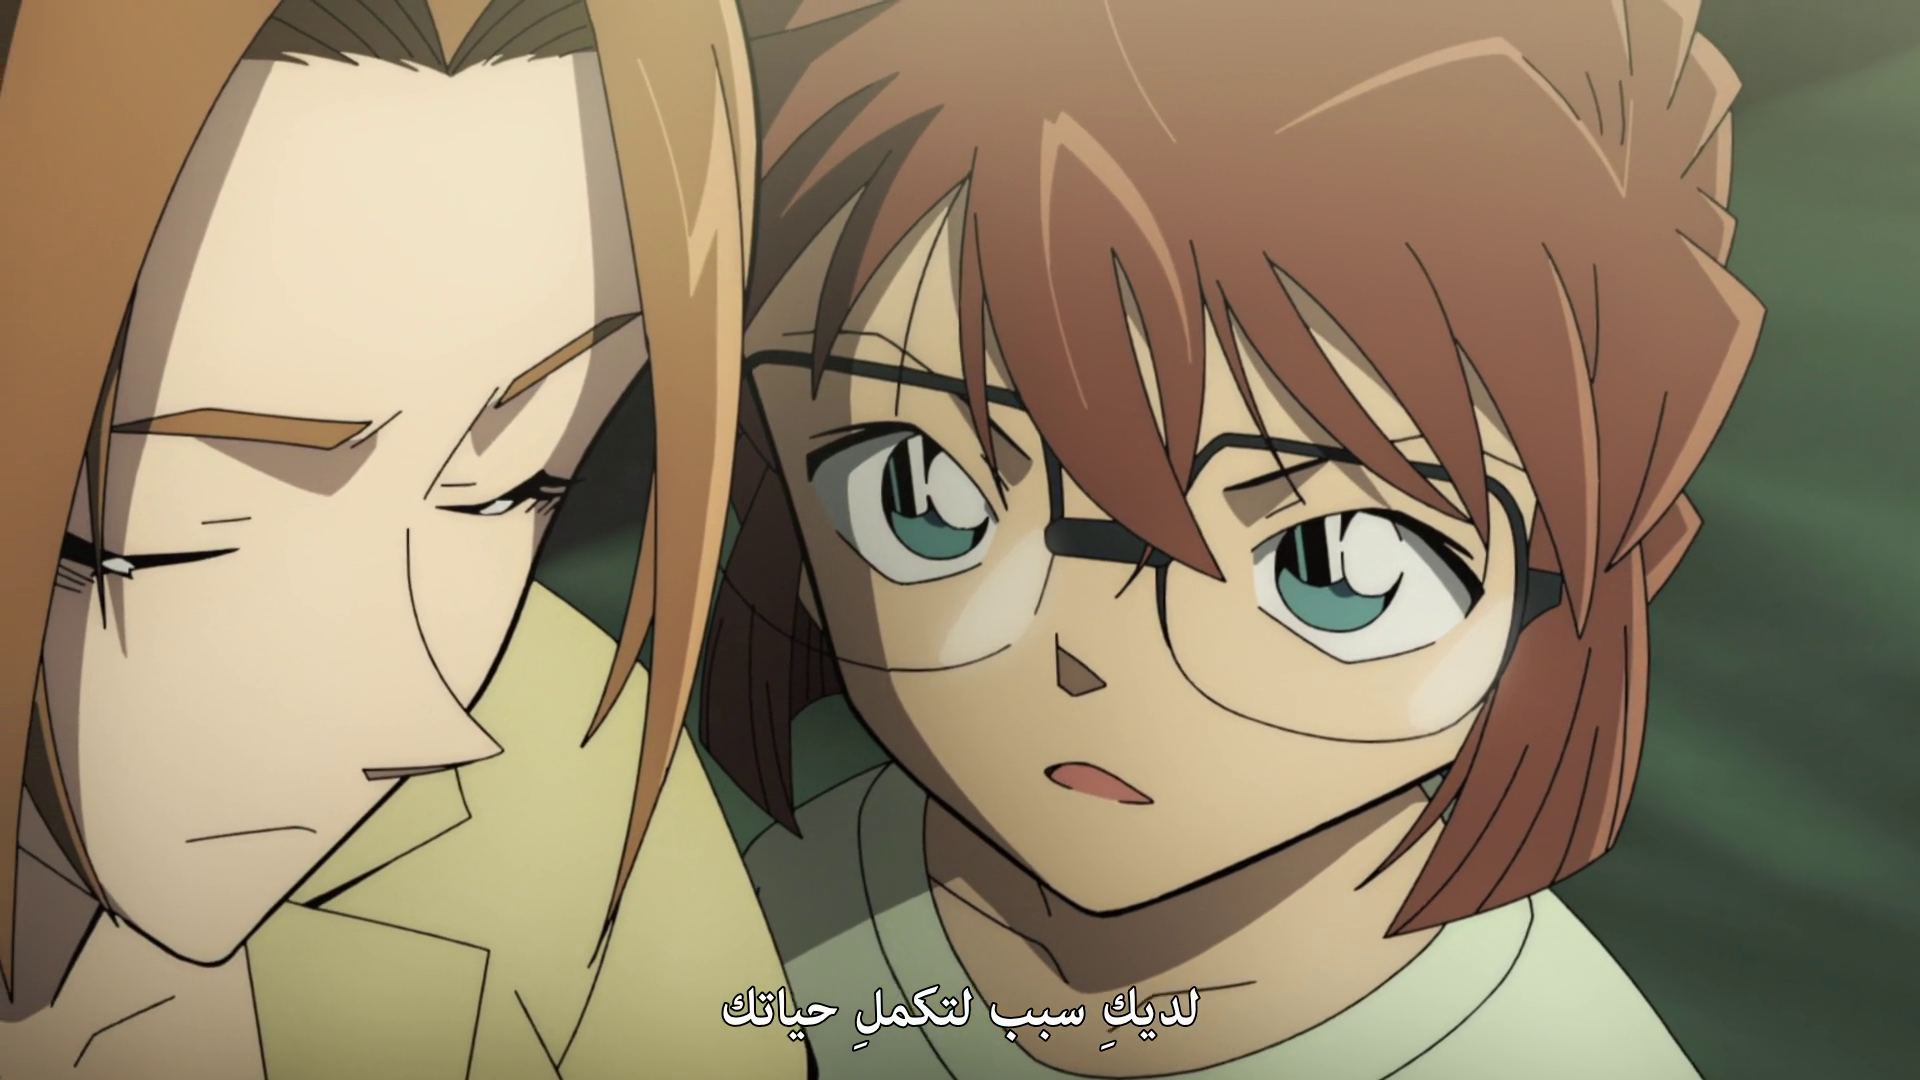

In [ ]:
# Step 4: Display a specific frame
def display_frame(part, frame_number):
    """
    Display a specific frame from a specified part of the video.

    Args:
        part (int): The index of the video part.
        frame_number (int): The frame number to display.
        base_dir (str): The base directory where the frames are stored.

    Returns:
        str or None: The path to the displayed frame if successful, otherwise None.
    """

    frames = sorted(glob.glob(os.path.join("/content/VideoFrames", f"frames_part_{part}/*.png")))
    if frame_number < len(frames):
      frame_path = frames[frame_number]
      display(Image(filename = frame_path))
      return frame_path
    else:
      print(f"Frame number {frame_number} is out of range for part {part}.")

frame_path = display_frame(2, 501)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Authenticate and get the Google Drive API service
def authenticate_drive_api():
    """
    Authenticate and get the Google Drive API service.

    Returns:
        service: An authorized Google Drive API service instance.
    """

    credentials_file = '/content/videoframeextractor.json'  # the path of JSON file
    credentials = Credentials.from_service_account_file(credentials_file)
    service = build('drive', 'v3', credentials=credentials)
    return service

# Function to create a folder in Google Drive
def create_drive_folder(service, folder_name, parent_folder_id=None):
    """
    Create a folder in Google Drive.

    Args:
        service: Authorized Google Drive API service instance.
        folder_name (str): Name of the folder to create.
        parent_folder_id (str, optional): ID of the parent folder. Defaults to None.

    Returns:
        str: ID of the created folder, or None if the creation failed.
    """

    folder_metadata = {
        'name': folder_name,
        'mimeType': 'application/vnd.google-apps.folder'
    }
    if parent_folder_id:
        folder_metadata['parents'] = [parent_folder_id]

    try:
        folder = service.files().create(body=folder_metadata, fields='id').execute()
        return folder.get('id')
    except HttpError as error:
        print(f'An error occurred: {error}')
        return None

# Function to upload a file to Google Drive
def upload_file_to_drive(service, file_path, folder_id):
    """
    Upload a file to Google Drive.

    Args:
        service: Authorized Google Drive API service instance.
        file_path (str): Path to the file to upload.
        folder_id (str): ID of the folder to upload the file to.

    Returns:
        str: ID of the uploaded file, or None if the upload failed.
    """

    file_metadata = {
        'name': os.path.basename(file_path),
        'parents': [folder_id]
    }
    media = MediaFileUpload(file_path, mimetype='image/png')
    try:
        file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
        return file.get('id')
    except HttpError as error:
        print(f'An error occurred while uploading the file: {error}')
        return None

# Function to make a file public and get its sharable link
def make_file_public_and_get_link(service, file_id):
    """
    Make a file public and get its sharable link.

    Args:
        service: Authorized Google Drive API service instance.
        file_id (str): ID of the file to make public.

    Returns:
        str: Sharable link of the file, or None if the operation failed.
    """
    permission = {
        'type': 'anyone',
        'role': 'reader',
    }
    try:
        service.permissions().create(fileId=file_id, body=permission).execute()
        sharable_link = f"https://drive.google.com/file/d/{file_id}/view?usp=sharing"
        return sharable_link
    except HttpError as error:
        print(f'An error occurred while making the file public: {error}')
        return None

# Path to your video parts and frames
frames_base_dir = '/content/VideoFrames'
parts_output_dir = '/content/video_parts'

# Use the correct parent folder ID
parent_folder_id = '1-q5AZR6K5SKpFNbNd-9_-o1ssL754b60'

# Authenticate and get the Google Drive API service
service = authenticate_drive_api()

# Ensure the service account is authenticated
print("Service account authenticated.")

# Create a folder in Google Drive
frames_folder_id = create_drive_folder(service, 'VideoFrames', parent_folder_id)

if frames_folder_id:
    # Upload sample frames
    frame_files = []
    for part in range(4):
        frames_output_dir = os.path.join(frames_base_dir, f"frames_part_{part}")
        frames = sorted(os.listdir(frames_output_dir))[100:105]  # Select 5 frames
        for frame in frames:
            frame_path = os.path.join(frames_output_dir, frame)
            frame_id = upload_file_to_drive(service, frame_path, frames_folder_id)
            if frame_id:
                frame_files.append(frame_id)

    # Make frames public and get sharable links
    sharable_links = []
    for file_id in frame_files:
        link = make_file_public_and_get_link(service, file_id)
        if link:
            sharable_links.append(link)

    # Print sharable links
    for link in sharable_links:
        print(link)
else:
    print("Failed to create the 'VideoFrames' folder in Google Drive.")


Service account authenticated.
https://drive.google.com/file/d/1vT_bDe5LDoxr_ptzedLFdgZxCUsAxQHU/view?usp=sharing
https://drive.google.com/file/d/1bi6SiKxfNKuKTQufbE1rZ3OmtCjNhwbk/view?usp=sharing
https://drive.google.com/file/d/1tUWqF1z_RTzVe5j6QY9JhysBblJ7pBu_/view?usp=sharing
https://drive.google.com/file/d/1tzuvnTaINyavw463cLBn9op12qMhz1ym/view?usp=sharing
https://drive.google.com/file/d/1AfdAIUw-K3e6YyOGLH0ayB6gXM1ziPQM/view?usp=sharing
https://drive.google.com/file/d/1KF_V-RjqAY8D3xJhZmAngFWd6LRrO35X/view?usp=sharing
https://drive.google.com/file/d/1SJTpG4rEVAlMcGyoeLeRHB84KoflsFXS/view?usp=sharing
https://drive.google.com/file/d/15tS1wtX5RCugNNgshKygdqOQsnyNNZBj/view?usp=sharing
https://drive.google.com/file/d/1ZD9BSEacGACGmIhS_KLZH7fSTAYrksA_/view?usp=sharing
https://drive.google.com/file/d/1WFResyMLmM9ScaYk44raKgN_2hcoEyzs/view?usp=sharing
https://drive.google.com/file/d/1yGMCfFmRBzKnxdzMpVv-RZZ6-MTsJd-D/view?usp=sharing
https://drive.google.com/file/d/1NE0yBHeE6PM9cxwu7l7Moxg